
# TelecomX — ETL de Churn_Clientes (Extra correlaciones)

Flujo: carga → exploración → limpieza → conversión numérica robusta → transformación → top 2 numéricas / top 2 categóricas → visualizaciones simples → conclusiones → exportación**.


In [1]:

import warnings, numpy as np, pandas as pd, io, requests, re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

print("Entorno listo. pandas:", pd.__version__)


Entorno listo. pandas: 2.2.2


## 📥 EXTRACCIÓN: carga y normalización básica (tu celda)

In [3]:

# 📥 EXTRACCIÓN: carga y normalización básica
import pandas as pd
import requests
from IPython.display import display

RAW_URL = "https://raw.githubusercontent.com/Alxs68/TelecomX_LATAM/main/TelecomX_Data.json"

resp = requests.get(RAW_URL, timeout=30)
resp.raise_for_status()
data = resp.json()

df_raw = pd.json_normalize(data, sep=".")
print("✅ Cargado. Forma:", df_raw.shape)
display(df_raw.sample(5))


✅ Cargado. Forma: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
3945,5386-THSLQ,No,Female,1,Yes,No,66,No,No phone service,DSL,No,Yes,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25
4908,6711-FLDFB,Yes,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.90,541.15
6242,8591-NXRCV,No,Female,0,No,No,41,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),74.65,3090.65
160,0257-KXZGU,No,Female,0,Yes,Yes,32,Yes,Yes,DSL,No,Yes,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),62.45,2045.55
1889,2675-DHUTR,No,Male,1,Yes,No,58,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.90,5780.7


## 🔎 Exploración inicial

In [4]:

df = df_raw.copy()
df.columns = [str(c).strip() for c in df.columns]
print("Columnas:", list(df.columns))
print("\nTipos de datos (inicio):")
print(df.dtypes)
print("\nNulos (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Columnas: ['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']

Tipos de datos (inicio):
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     obje

## 🧹 Limpieza básica

In [5]:

# Detectar columna de churn (YES/NO/NaN)
candidatos = ["churn","is_churn","churn_flag","target","y"]
CHURN_COL = next((c for c in df.columns if str(c).lower() in candidatos), df.columns[-1])

# Estandarizar objetivo a YES/NO/NaN
df[CHURN_COL] = df[CHURN_COL].astype(str).str.strip().str.upper()
df[CHURN_COL] = df[CHURN_COL].where(df[CHURN_COL].isin({"YES","NO"}), np.nan)

# Mapear binarios en otras columnas (SI/NO/TRUE/FALSE -> 0/1)
def map_bin(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in ["si","sí","true","verdadero","1","y","yes"]: return 1
    if s in ["no","false","falso","0","n"]: return 0
    return v

for col in df.columns:
    if col == CHURN_COL:
        continue
    if df[col].dtype == "O":
        uniq = set(str(x).strip().lower() for x in df[col].dropna().unique())
        if uniq.issubset({"si","sí","no","true","false","verdadero","falso","1","0","y","n","yes"}):
            df[col] = df[col].map(map_bin)

# Eliminar duplicados
df = df.drop_duplicates().copy()

print("Objetivo detectado:", CHURN_COL)
print("Conteo objetivo (YES/NO/NaN):")
print(df[CHURN_COL].value_counts(dropna=False))


Objetivo detectado: Churn
Conteo objetivo (YES/NO/NaN):
Churn
NO     5174
YES    1869
NaN     224
Name: count, dtype: int64


## 🔢 Conversión numérica robusta (maneja $, %, comas/puntos)

In [6]:

def smart_coerce_numeric(df_in: pd.DataFrame, exclude_cols=None, min_ratio=0.90):
    df_out = df_in.copy()
    exclude_cols = set(exclude_cols or [])
    converted = []
    for c in df_out.columns:
        if c in exclude_cols:
            continue
        s = df_out[c]
        if s.dtype != 'O':
            continue

        # limpiar espacios y símbolos comunes
        t = s.astype(str).str.strip()
        t = t.str.replace(r'\s', '', regex=True)
        t = t.str.replace(r'[%$€£]', '', regex=True)

        # Europeo: 1.234,56 -> 1234.56
        t2 = t.where(~t.str.match(r'^\d{1,3}(\.\d{3})+,\d+$'),
                     t.str.replace('.', '', regex=False).str.replace(',', '.', regex=False))
        # USA: 1,234.56 -> 1234.56
        t3 = t2.where(~t2.str.match(r'^\d{1,3}(,\d{3})+\.\d+$'),
                      t2.str.replace(',', '', regex=False))
        # Solo coma decimal: 123,45 -> 123.45
        t4 = t3.where(~((t3.str.contains(',')) & (~t3.str.contains('\.'))),
                      t3.str.replace(',', '.', regex=False))

        num = pd.to_numeric(t4, errors='coerce')
        if num.notna().mean() >= min_ratio:
            df_out[c] = num
            converted.append(c)
    return df_out, converted

# Aplicar antes de separar
df, converted_cols = smart_coerce_numeric(df, exclude_cols=[CHURN_COL])
print("Convertidas a numéricas:", converted_cols)
print("\nTipos de datos tras conversión:")
print(df.dtypes)


Convertidas a numéricas: ['account.Charges.Total']

Tipos de datos tras conversión:
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner               int64
customer.Dependents            int64
customer.tenure                int64
phone.PhoneService             int64
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     object
internet.TechSupport          object
internet.StreamingTV          object
internet.StreamingMovies      object
account.Contract              object
account.PaperlessBilling       int64
account.PaymentMethod         object
account.Charges.Monthly      float64
account.Charges.Total        float64
dtype: object


## 🔀 Transformación y tipos

In [8]:
# Separar etiquetados / sin etiqueta
df_score = df[df[CHURN_COL].isna()].copy()
df_ml    = df[df[CHURN_COL].notna()].copy()
df_ml["churn_flag"] = df_ml[CHURN_COL].map({"NO":0, "YES":1}).astype(int)

# Re-aplicar coerción a df_ml (por si quedó algo en texto)
df_ml, converted_cols_ml = smart_coerce_numeric(df_ml, exclude_cols=[CHURN_COL, "churn_flag"])
print("Convertidas a numéricas en df_ml:", converted_cols_ml)

# Detectar tipos
# Include 'account.Charges.Total' in numerical columns
num_cols = [c for c in df_ml.columns if pd.api.types.is_numeric_dtype(df_ml[c]) and c!="churn_flag"]
cat_cols = []
for c in df_ml.columns:
    if c in [CHURN_COL,"churn_flag"]:
        continue
    if (df_ml[c].dtype=="O") or (pd.api.types.is_integer_dtype(df_ml[c]) and df_ml[c].nunique()<=12):
        cat_cols.append(c)

# Exclude ID-like columns, but not 'account.Charges.Total'
ID_LIKE = [c for c in num_cols if df_ml[c].nunique() > 0.9*len(df_ml) and c != 'account.Charges.Total']
num_cols = [c for c in num_cols if c not in ID_LIKE]


# Normalizar texto de categóricas
for c in cat_cols:
    df_ml[c] = df_ml[c].astype(str).str.strip().str.upper()

print("Resumen de columnas detectadas:")
print("  - Objetivo:", CHURN_COL)
print("  - Numéricas (", len(num_cols), "):", num_cols)
print("  - Categóricas (", len(cat_cols), "):", cat_cols)
if ID_LIKE:
    print("  - Omitidas por parecer IDs:", ID_LIKE)

Convertidas a numéricas en df_ml: []
Resumen de columnas detectadas:
  - Objetivo: Churn
  - Numéricas ( 8 ): ['customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'account.PaperlessBilling', 'account.Charges.Monthly', 'account.Charges.Total']
  - Categóricas ( 17 ): ['customerID', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']


## ⭐ Selección Top 2 (numéricas y categóricas)

In [16]:
# Top 2 numéricas por |r Pearson| con churn_flag
r_list = []
for c in num_cols:
    s = pd.to_numeric(df_ml[c], errors="coerce")
    y = df_ml["churn_flag"]
    m = s.notna() & y.notna()
    if m.sum() > 2:
        r = np.corrcoef(s[m], y[m])[0,1]
        r_list.append((c, r))
r_sorted = sorted(r_list, key=lambda t: abs(t[1]), reverse=True)
TOP_NUM = [v for v,_ in r_sorted[:2]]

# Top 2 categóricas por spread de churn (max - min)
spread_scores = []
# Ensure customerID is not in cat_cols for this calculation
cat_cols_for_spread = [c for c in cat_cols if c != 'customerID']
for c in cat_cols_for_spread:
    tab = (df_ml.groupby(c)[CHURN_COL]
           .agg(n="count", churn_yes=lambda s: (s=="YES").sum())
           .assign(rate=lambda t: t["churn_yes"]/t["n"]))
    if tab.shape[0] >= 2:
        spread = float(tab["rate"].max() - tab["rate"].min())
        spread_scores.append((c, spread))
spread_sorted = sorted(spread_scores, key=lambda t: t[1], reverse=True)
TOP_CAT = [v for v,_ in spread_sorted[:2]]

print("Top 2 numéricas:", TOP_NUM)
print("Top 2 categóricas:", TOP_CAT)

Top 2 numéricas: ['customer.tenure', 'account.Charges.Total']
Top 2 categóricas: ['account.Contract', 'internet.InternetService']


## 📊 Visualizaciones (simples)

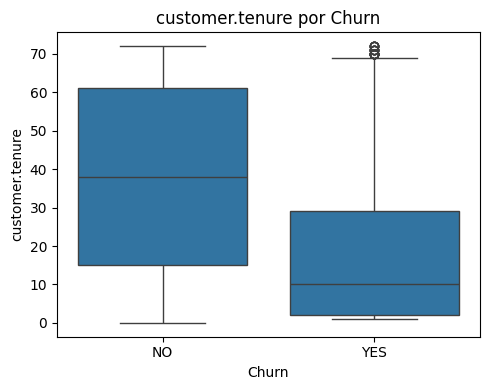

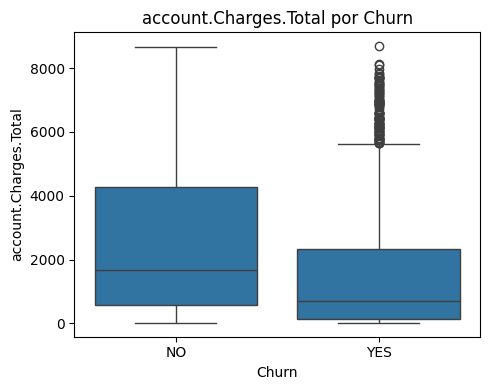

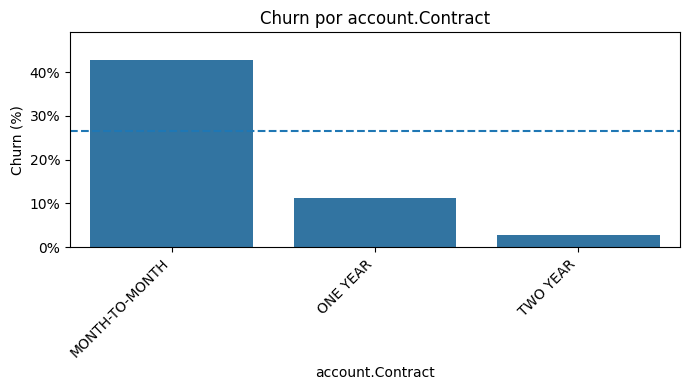

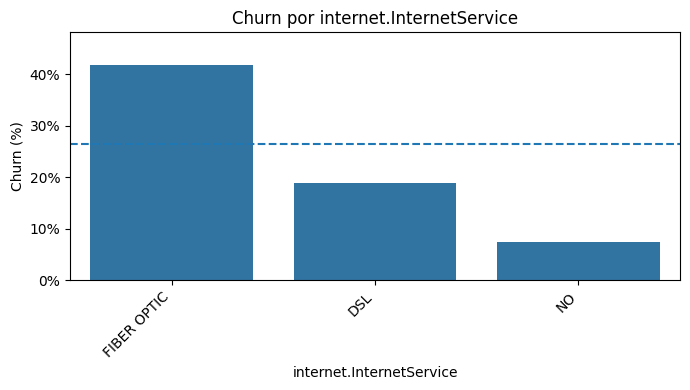

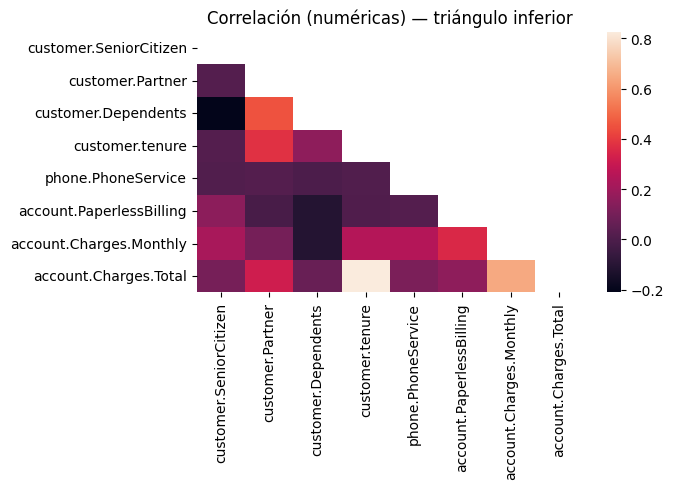

In [17]:

# 8.1 Numéricas (boxplot por clase)
for c in TOP_NUM:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=df_ml, x=CHURN_COL, y=c)
    plt.title(f"{c} por {CHURN_COL}")
    plt.tight_layout()
    plt.show()

# 8.2 Categóricas (barras churn % + baseline)
baseline = df_ml["churn_flag"].mean() if len(df_ml)>0 else 0.0

for c in TOP_CAT:
    tab = (df_ml.groupby(c)[CHURN_COL]
           .agg(n="count", churn_yes=lambda s: (s=="YES").sum())
           .assign(rate=lambda t: t["churn_yes"]/t["n"])
           .sort_values("rate", ascending=False))
    plt.figure(figsize=(7,4))
    ax = sns.barplot(data=tab.reset_index(), x=c, y="rate")
    ax.set_ylabel("Churn (%)")
    ax.set_ylim(0, max(0.01, float(tab["rate"].max())*1.15))
    yt = ax.get_yticks()
    ax.set_yticklabels([f"{y*100:0.0f}%" for y in yt])
    ax.axhline(baseline, linestyle="--")
    ax.set_title(f"Churn por {c}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 8.3 Un solo interactivo (Plotly) para la categórica más influyente
if len(TOP_CAT) >= 1:
    c = TOP_CAT[0]
    tab = (df_ml.groupby(c)[CHURN_COL]
           .agg(n="count", churn_yes=lambda s: (s=="YES").sum())
           .assign(rate=lambda t: t["churn_yes"]/t["n"])
           .sort_values("rate", ascending=False)
           .reset_index())
    fig = px.bar(tab, x=c, y="rate", hover_data=["n","churn_yes"], title=f"Churn por {c} (interactivo)")
    fig.show()

# 8.4 (Opcional) Correlación numérica — triángulo inferior
if len([c for c in num_cols if c!="churn_flag"]) >= 2:
    cols = [c for c in num_cols if df_ml[c].dropna().nunique()>1]
    if len(cols) >= 2:
        corr = df_ml[cols].corr(method="pearson")
        import numpy as np
        mask = np.triu(np.ones_like(corr, dtype=bool))
        plt.figure(figsize=(7,5))
        sns.heatmap(corr, mask=mask, annot=False)
        plt.title("Correlación (numéricas) — triángulo inferior")
        plt.tight_layout()
        plt.show()


## 🧭 Conclusiones (breves)

In [18]:

conclusiones = []

if len(TOP_NUM) > 0:
    for v in TOP_NUM:
        s = pd.to_numeric(df_ml[v], errors="coerce")
        y = df_ml["churn_flag"]
        m = s.notna() & y.notna()
        r = np.corrcoef(s[m], y[m])[0,1] if m.sum()>2 else 0.0
        signo = "positiva" if r>=0 else "negativa"
        conclusiones.append(f"- {v}: relación {signo} (r={r:0.2f}).")

if len(TOP_CAT) > 0:
    for c in TOP_CAT:
        tab = (df_ml.groupby(c)[CHURN_COL]
               .agg(n="count", churn_yes=lambda s: (s=='YES').sum())
               .assign(rate=lambda t: t['churn_yes']/t['n'])
               .sort_values('rate', ascending=False))
        top_cat = str(tab.index[0])
        top_rate = float(tab['rate'].iloc[0])
        base = float(df_ml['churn_flag'].mean())
        conclusiones.append(f"- {c}: mayor churn en '{top_cat}' ({top_rate*100:0.1f}%) vs base ({base*100:0.1f}%).")

if not conclusiones:
    conclusiones.append("- No se observaron señales claras. Revisa calidad de datos y columnas detectadas.")

print("Conclusiones (breves):")
for c in conclusiones[:6]:
    print(c)


Conclusiones (breves):
- customer.tenure: relación negativa (r=-0.35).
- account.Charges.Total: relación negativa (r=-0.20).
- account.Contract: mayor churn en 'MONTH-TO-MONTH' (42.7%) vs base (26.5%).
- internet.InternetService: mayor churn en 'FIBER OPTIC' (41.9%) vs base (26.5%).


## 💾 Exportación

In [ ]:

ml_csv = "TelecomX_churn_ML_ready.csv"
score_csv = "TelecomX_churn_unlabeled_to_score.csv"
df_ml.to_csv(ml_csv, index=False, encoding="utf-8-sig")
df_score.to_csv(score_csv, index=False, encoding="utf-8-sig")
print("Generados:")
print("-", ml_csv)
print("-", score_csv)


### 📊 Visualizaciones Adicionales (Violin Plots)

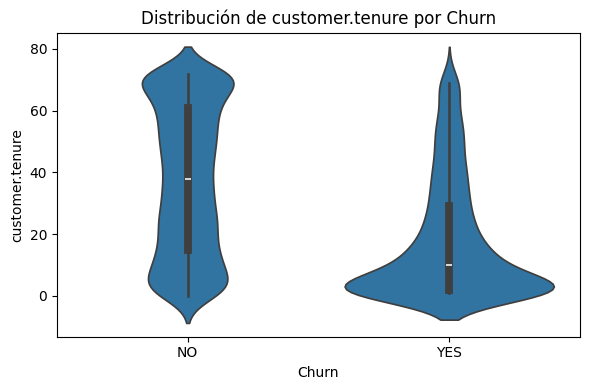

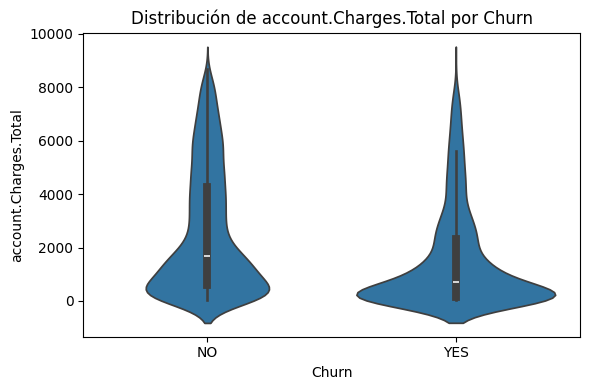

In [19]:
# Violin plots for top numerical features
for c in TOP_NUM:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df_ml, x=CHURN_COL, y=c)
    plt.title(f"Distribución de {c} por {CHURN_COL}")
    plt.tight_layout()
    plt.show()

## Informe de Análisis de Churn de Clientes TelecomX

Este informe presenta los hallazgos clave del análisis exploratorio de datos realizado sobre el conjunto de datos de Churn de Clientes TelecomX, identificando factores influyentes en la deserción de clientes y sugiriendo posibles acciones.

**Insights y Conclusiones:**

Basándonos en el análisis de las características numéricas y categóricas, así como en las visualizaciones generadas, las principales conclusiones son:

*   **Antigüedad del Cliente (`customer.tenure`):** Existe una clara relación negativa con el churn. Los clientes con mayor antigüedad (`customer.tenure`) tienden a tener una menor tasa de churn. Esto se observa en los boxplots y violin plots, donde los clientes que no churnearon tienen una antigüedad promedio significativamente mayor.
*   **Cargo Total (`account.Charges.Total`):** Similar a la antigüedad, el cargo total (`account.Charges.Total`) también muestra una relación negativa con el churn. Clientes con cargos totales más altos (acumulados a lo largo de su relación con la empresa) son menos propensos a churnear. Esto sugiere que los clientes con una mayor inversión a largo plazo en servicios son más leales.
*   **Tipo de Contrato (`account.Contract`):** Este es un factor categórico altamente influyente. Los clientes con contratos mes a mes (`MONTH-TO-MONTH`) tienen una tasa de churn considerablemente más alta en comparación con aquellos con contratos de uno o dos años. Esto indica que los contratos a largo plazo fomentan la retención.
*   **Servicio de Internet (`internet.InternetService`):** El tipo de servicio de internet también impacta el churn. Los clientes con servicio de Fibra Óptica (`FIBER OPTIC`) presentan una tasa de churn más alta que aquellos con DSL o sin servicio de internet. Esto podría estar relacionado con expectativas de rendimiento, precio o problemas técnicos específicos de la fibra óptica.
*   **Otras Características:** Si bien otras características como `customer.SeniorCitizen`, `customer.Partner`, `customer.Dependents`, `phone.PhoneService`, `account.PaperlessBilling`, `account.Charges.Monthly`, `phone.MultipleLines`, `internet.OnlineSecurity`, `internet.OnlineBackup`, `internet.DeviceProtection`, `internet.TechSupport`, `internet.StreamingTV`, `internet.StreamingMovies`, y `account.PaymentMethod` pueden tener alguna influencia, las identificadas como top 2 numéricas y categóricas muestran las señales más fuertes de relación con el churn en este análisis inicial.

**Acciones Sugeridas:**

Basado en estas conclusiones, se sugieren las siguientes acciones para reducir el churn:

1.  **Fomentar Contratos a Largo Plazo:** Implementar estrategias para incentivar a los clientes mes a mes a cambiarse a contratos de uno o dos años, ofreciendo descuentos, beneficios adicionales o planes más atractivos.
2.  **Programas de Retención para Clientes con Baja Antigüedad y Cargos Totales Bajos:** Identificar a los clientes con menor antigüedad y cargos totales y dirigirles ofertas o comunicaciones personalizadas para aumentar su compromiso y demostrar el valor a largo plazo de los servicios.
3.  **Investigar el Churn en Fibra Óptica:** Realizar un análisis más profundo de los clientes con servicio de fibra óptica para identificar las causas específicas de su mayor tasa de churn. Esto podría implicar encuestas, análisis de tickets de soporte técnico o evaluación de la calidad del servicio en áreas con alta concentración de usuarios de fibra óptica y alto churn.
4.  **Monitorear Continuamente las Características Clave:** Establecer un sistema de monitoreo regular de las características identificadas como influyentes (`customer.tenure`, `account.Charges.Total`, `account.Contract`, `internet.InternetService`) para detectar cambios en las tendencias de churn y ajustar las estrategias de retención según sea necesario.
5.  **Explorar Otras Características:** Si bien nos centramos en las top 2, un análisis más exhaustivo podría incluir la exploración de la interacción entre diferentes características y su impacto en el churn para identificar segmentos de clientes de alto riesgo más específicos.

Este informe proporciona una base para comprender los impulsores del churn en TelecomX. Las acciones sugeridas buscan capitalizar los hallazgos para desarrollar estrategias de retención más efectivas.